# Churn customers

## Imports

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

file = "churn.csv"

## Helpers

In [47]:
def annot_max(x,y, ax=None):
    # auto annotate the max point of a fig given its x and y
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.0f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

# df_Class

In [272]:
class df_class:
    
    def __init__(self,csv_file_name, label='churn', index_col='customerID'):   #can receive a different label column   
        self.name = os.path.splitext(csv_file_name)[0]
        self.df = pd.read_csv(csv_file_name ,index_col=index_col) \
            .rename(columns=str.lower) \
            .replace(to_replace = ['Yes','No','No phone service','No internet service'],value = [1,0,0,0])
        self.label = label
        try:
            self.df["totalcharges"] = pd.to_numeric(self.df["totalcharges"].replace(" ", 0))
            self.df['years']=self.df['tenure']//12
        except Exception as e:
            print(f'error: {e}')
        
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
    
    def describe_df(self):
        # df shape
        print(f'The DataFrame has {self.df.shape[0]} rows and {self.df.shape[1]} columns (including index, label and calculated columns)')
        print('')
        
        # percent of label == True
        pct_label = dfc.df[dfc.label].sum()/dfc.df[dfc.label].count()*100
        print(f'Percent of {dfc.label}: {pct_label} %')
        print('')
        
        # calculate the number of unique values for each column
        unique_counts = self.df.nunique()
        # assign each column to a group based on the number of unique values
        groups = {'1 value': [], '2 values': [], '3-6 values': [], '>6 values': []}
        for col in unique_counts.index:
            count = unique_counts[col]
        # no variance in data, columns can be dropped
            if count == 1: 
                groups['1 value'].append(col)
        # 2 values - can be transformed to binary
            elif count == 2:
                groups['2 values'].append(col)
        # 3-6 values: can be transformed to binary or dummies
            elif count <= 6:
                groups['3-6 values'].append(col)
        # >6 values: probably numeric values (6 was an arbitrary choice)
            else:
                groups['>6 values'].append(col)

        # print the groups for each column
        print('Columns grouped by the number of possible values:')
        for k, v in groups.items():
            print(k, v)
            print('')
    
    def check_before_model(self):
        label = self.label
        if self.df.isna().sum().sum() == 0:
            print('The data contains no nulls')
        else:
            print('Data contains nulls:')
            self.correct_nulls()
    
    def correct_nulls(self):
        # get the sum of missing values for each column
        na_sum = self.df.isna().sum()
        print(na_sum.loc[na_sum > 0])

        # get the list of columns with missing values
        cols_with_na = na_sum.loc[na_sum > 0].index.tolist()
        for col in cols_with_na:
            replacement_value = input(f'Enter value to replace nulls in the column {col} (default=0): ')
            if replacement_value == np.nan: # pressing enter deaults to zero
                replacement_value=0                                     
            self.df[col].fillna(replacement_value, inplace=True)
        self.check_before_model()

    def features_correlation_to_label(self):
        label = self.label
        fig = self.df.corr()[label].drop(label).plot(kind='barh')
        plt.show()
    
    def corr(self):
        label = self.label
        corr = self.df.corr()
        sns.heatmap(corr, annot=False, cmap='coolwarm')
 
    def histplot(self,column='years'):      
        label = self.label
        cross_tab_prop=pd.crosstab(index=self.df[column],columns=self.df[label],normalize='index')
        cross_tab=pd.crosstab(index=self.df[column],columns=self.df[label])
        cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(10, 6))

        plt.legend(loc="lower right", labels = ['{}: False'.format(label),'{}: True'.format(label)])
        plt.xlabel(column)
        plt.ylabel("Proportion")
        plt.title('%{} over {}'.format(label, column))

        for n, x in enumerate([*cross_tab.index.values]):
            for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                                  cross_tab.loc[x],
                                                  cross_tab_prop.loc[x].cumsum()):

                plt.text(x=n - 0.0,
                         y=(y_loc - proportion) + (proportion / 2),
                         s=f'{count}\n{np.round(proportion * 100, 0).astype(int)}%', 
                         color="black",
                         horizontalalignment='center',
                         fontsize=8
                         )
        plt.show()
     
    def train_test(self):
        from sklearn.model_selection import train_test_split
        label = self.label
        df_dummies = pd.get_dummies(self.df, drop_first=True)
        train, test = train_test_split(df_dummies, test_size=0.2, random_state=0, shuffle=True)
        x_train = train.drop(label, axis=1)
        y_train = train[label]
        x_test, y_test = test.drop(label, axis=1), test[label]
        return (x_train, y_train, x_test, y_test)

    def accuracy_score(self, y_test, y_test_pred):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y_test, y_test_pred)
    
    def decision_tree(self, max_depth=5, draw=False):
        from sklearn.tree import DecisionTreeClassifier # Importing the algorithm        
        label = self.label
        (x_train, y_train, x_test, y_test) = self.train_test()

        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(x_train, y_train) # running\training the algorithm with the train data
        y_test_pred_DecisionTree = clf.predict(x_test) # making a prediction based on "test" data features

        if draw:
            from sklearn.tree import DecisionTreeClassifier, export_graphviz
            from IPython.display import SVG
            from graphviz import Source
            from IPython.display import display

            # this is a function that we can always use for plotting decision trees, the function expects 3 arg as follows
            def plot_tree(tree, features, labels):
                graph = Source(export_graphviz(tree, feature_names=features, class_names=labels, filled = True))
                display(SVG(graph.pipe(format='svg')))

            plot_tree(clf, x_train.columns, ['{}: False'.format(label), '{}: True'.format(label)])
        accuracy_score = self.accuracy_score(y_test, y_test_pred_DecisionTree)
        return accuracy_score
    
    def random_forest(self, n_estimators=100, max_depth=3, draw=False):
        from sklearn.ensemble import RandomForestClassifier # Importing the algorithm
        label = self.label
        (x_train, y_train, x_test, y_test) = self.train_test()
        
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=1)
        model.fit(x_train, y_train) # running\training the algorithm with the train data
        y_test_pred_RandomForest = model.predict(x_test) # making a prediction based on "test" data features
                
        
        feature_importances = model.feature_importances_
        features = x_train.columns # all the features
        stats = pd.DataFrame({'feature':features, 'importance':feature_importances}) # creating the data frame
        stats.sort_values('importance', ascending=False) # Sorting the data frame
        stats_sort = stats.sort_values('importance', ascending=True)
        if draw:    
            stats_sort.plot(y='importance', x='feature', kind='barh')
            plt.title('Feature Importance of Random Forest');
            

        # Use the trained random forest model to predict the probability of churn for each customer who hasn't churned
        df_for_proba = df[df['churn']==0].copy()
        df_for_proba = pd.get_dummies(df_for_proba, drop_first=True).drop(label, axis=1)
        print(df_for_proba.columns)
        probability_to_churn = model.predict_proba(df_for_proba)
        df_for_proba['churn_proba'] = probability_to_churn[:, 1]
        # Print the resulting DataFrame
        top_20_risk_to_churn = df_for_proba['churn_proba'].sort_values(ascending=False).head(20)
        print(top_20_risk_to_churn)
        
        
        

        accuracy_score = self.accuracy_score(y_test, y_test_pred_RandomForest)

        return accuracy_score, stats
    
    def knn(self, n_neighbors=26):
        from sklearn.neighbors import KNeighborsClassifier  # Importing the algorithm
        from sklearn.preprocessing import StandardScaler # import the libraries
        
        import warnings # todo: 
        warnings.simplefilter("ignore", FutureWarning)

        scaler = StandardScaler() # define
        (x_train, y_train, x_test, y_test) = self.train_test()
        x_train_scaled = scaler.fit_transform(x_train) # Fit to data, then transform it.
        x_test_scaled = scaler.transform(x_test) # Perform standardization by centering and scaling

        
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        clf.fit(x_train_scaled, y_train)

        y_test_pred_Knn_Scaled = clf.predict(x_test_scaled)

        accuracy_score = self.accuracy_score(y_test, y_test_pred_Knn_Scaled)
        
        return accuracy_score
    
    def compare_decision_tree_depths(self, depths=range(3,12), draw=False):
        accuracies = np.array([self.decision_tree(i) for i in depths])
        if draw:
            fig = sns.lineplot(x=depths, y = accuracies).set(title='Accuracy of model over tree depth', xlabel='Tree depth', ylabel='Accuracy')
            annot_max(depths,accuracies)

        d = {'accuracy': np.amax(accuracies),
             'max_depth':np.argmax(accuracies)+min(depths)}      

        return d
    
    def compare_random_forest(self, estimators_list=range(1,101,5), depths=[3, 6, 9], draw=False):
        results = []
        for n in estimators_list:
            for d in depths:
                accuracy = self.random_forest(n_estimators=n, max_depth=d)[0]
                results.append((n, d, accuracy))
        df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'accuracy'])
        
        if draw:
            sns.lineplot(x='n_estimators', y='accuracy', hue='max_depth', data=df).set(title='Random Forest Accuracy over n_estimators and depths')
            annot_max(df['n_estimators'],df['accuracy'])
        
        id_max = df.accuracy.idxmax()

        d = {'accuracy': df.loc[id_max,'accuracy'],
             'n_estimators':df.loc[id_max,'n_estimators'],
             'max_depth':df.loc[id_max,'max_depth']}

        return d
    
    def compare_knn(self, neighbours=[5, 10, 20, 40], draw=False):
        accuracies = np.array([self.knn(i) for i in neighbours])
        if draw:
            fig = sns.lineplot(x=neighbours, y=accuracies).set(title='Accuracy over n neighbours', xlabel='Neighbours', ylabel='Accuracy')
            annot_max(neighbours, accuracies)
        k={}
        k['accuracy'] = np.amax(accuracies)
        k['neighbours'] = neighbours[np.argmax(accuracies)]
        return k
    
    def compare_methods(self):
        accs = {}
        accs['Decision tree'] = self.compare_decision_tree_depths(draw=False)
        accs['Random forest'] = self.compare_random_forest(draw=False)
        accs['KNN']           = self.compare_knn(draw=False)
        accs['Benchmark']     = self.get_benchmark_accuracy()
      
        max_len = max(len(key) for key in accs.keys())

        # print keys and values with values aligned
        for key, value in accs.items():
            print('{:{}} {}'.format(key, max_len, value))
    
        return accs
    
    def add_columns_counter(self, columns_list: list):
        """
        Takes a list of columns from the df and sums them in a new column 'columns_counter'
        
        """
        self.df['columns_counter'] = self.df[columns_list].sum(axis=1, numeric_only=True)
        show = columns_list + ['columns_counter']
        
        return self.df.loc[:,show]
    
    def get_benchmark_accuracy(self):
        label = self.label
        (x_train, y_train, x_test, y_test) = self.train_test()
        # The benchmark would be the most common label in the train set
        benchmark_value = y_train.value_counts().idxmax() # zero
        y_test_pred_Benchmark = np.ones(len(x_test))*benchmark_value
        benchmark_acc = self.accuracy_score(y_test, y_test_pred_Benchmark)

        return  {'accuracy': benchmark_acc, 'benchmark_value': benchmark_value}       
        
        
dfc = df_class(file)


In [273]:
pd.set_option('display.max_rows', 60)
dfc.random_forest()



Index(['seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice',
       'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'paperlessbilling',
       'monthlycharges', 'totalcharges', 'years', 'gender_Male',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'contract_One year', 'contract_Two year',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')
customerID
0021-IKXGC    0.638834
7577-SWIFR    0.635658
3878-AVSOQ    0.633564
9603-OAIHC    0.633564
9605-WGJVW    0.633564
4912-PIGUY    0.633520
4273-MBHYA    0.630381
1452-VOQCH    0.629855
1628-BIZYP    0.629291
2545-EBUPK    0.628942
7439-DKZTW    0.628250
1941-HOSAM    0.626451
7465-ZZRVX    0.624585
1640-PLFMP    0.624585
5542-TBBWB    0.624585
2018-QKYGT    0.624211
5150-ITWWB    0.623975
4927-WWOOZ    0.613870
3489-HHPFY    0.612312
9799-C

(0.7707594038325053,
                                   feature  importance
 0                           seniorcitizen    0.009429
 1                                 partner    0.004595
 2                              dependents    0.008281
 3                                  tenure    0.156695
 4                            phoneservice    0.001391
 5                           multiplelines    0.002826
 6                          onlinesecurity    0.025250
 7                            onlinebackup    0.001872
 8                        deviceprotection    0.001808
 9                             techsupport    0.015041
 10                            streamingtv    0.003727
 11                        streamingmovies    0.004864
 12                       paperlessbilling    0.039200
 13                         monthlycharges    0.084906
 14                           totalcharges    0.075102
 15                                  years    0.184814
 16                            gender_Male  

In [ ]:
Start time: Sat Feb 25 02:04:43 2023
Decision tree {'accuracy': 0.794889992902768, 'max_depth': 5}
Random forest {'accuracy': 0.7934705464868701, 'n_estimators': 91, 'max_depth': 9}
KNN           {'accuracy': 0.7920511000709723, 'neighbours': 40}
Benchmark     {'accuracy': 0.7388218594748048, 'benchmark_value': 0}
Total runtime: 13.12 seconds

# EDA

## Dataset shape and label distribution

In [118]:
dfc.describe_df()

The DataFrame has 7043 rows and 22 columns (including index, label and calculated columns)

Percent of churn: 26.536987079369588 %

Columns grouped by the number of possible values:

1 value []

2 values ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'paperlessbilling', 'churn']

3-6 values ['internetservice', 'contract', 'paymentmethod']

>6 values ['tenure', 'monthlycharges', 'totalcharges', 'monthlycharges_group', 'years']



## Histograms

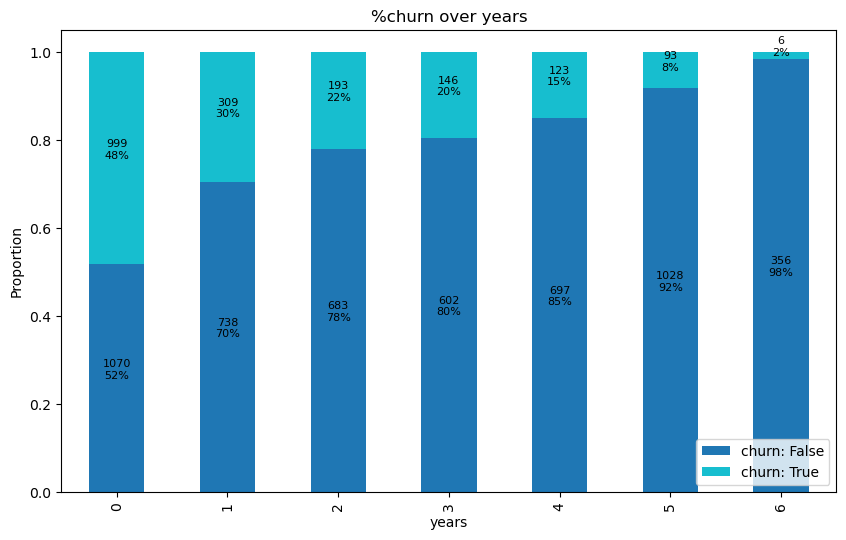

In [6]:
dfc.histplot()
# The more years a customer stays with us, the less chance for him to churn. 
# Prone to churn especially in the first year.

In [19]:
dfc.df.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'churn', 'years'],
      dtype='object')

In [20]:
# The same function above works with different columns


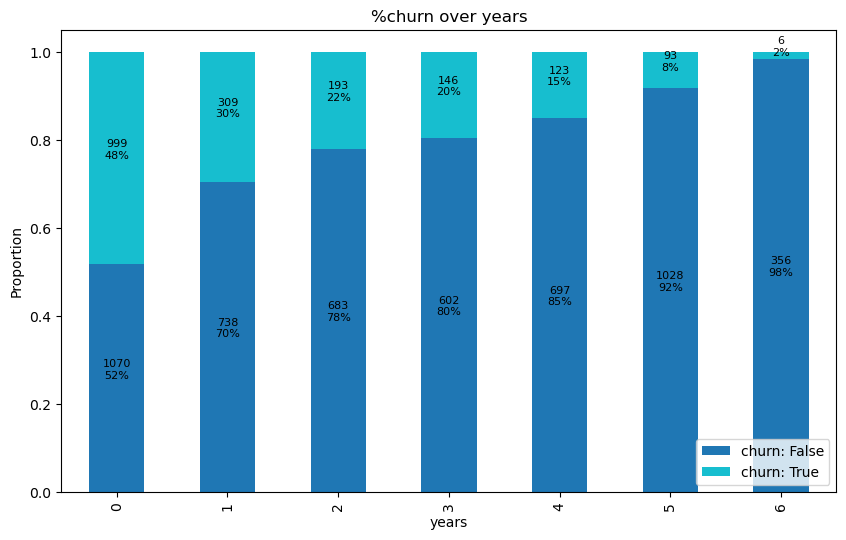

In [225]:
dfc.histplot('years')

C:\Users\amnon\AppData\Local\Temp\ipykernel_34736\4048213285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['churn_perc'] = df.groupby('tenure')['churn'].transform(lambda x: x.sum() / len(x))


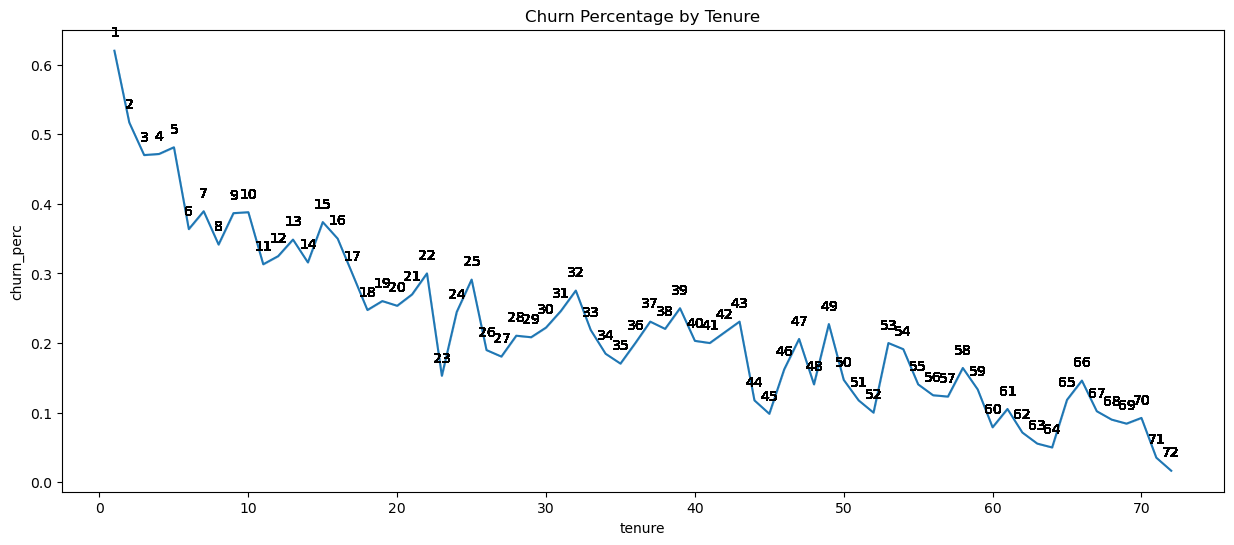

In [81]:
# df = dfc.df[df['tenure']>0]
df['churn_perc'] = df.groupby('tenure')['churn'].transform(lambda x: x.sum() / len(x))
pd.set_option('display.max_rows', None)

table = pd.pivot_table(data=df, values='churn_perc', index='tenure').round(2)
# print(table)

# Create a line plot of churn percentage per tenure
# sns.lineplot(data=df, x='tenure', y='churn_perc')
plt.figure(figsize=(15, 6))
ax = sns.lineplot(data=df, x='tenure', y='churn_perc')
for x, y in zip(df['tenure'], df['churn_perc']):
    ax.annotate(f'{x}', xy=(x, y), textcoords='offset points', xytext=(0, 10), ha='center')
plt.title('Churn Percentage by Tenure')

# Show the plot
plt.show()


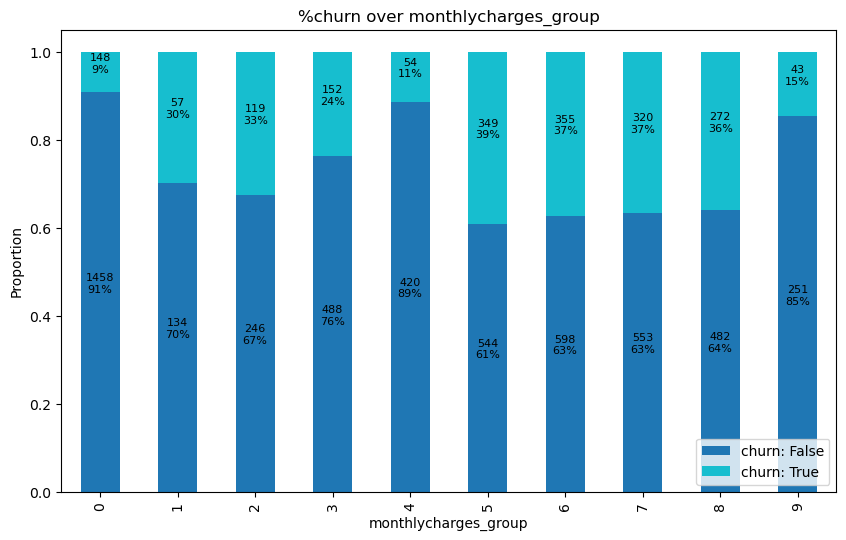

In [84]:
dfc.histplot('monthlycharges_group')

<AxesSubplot: >

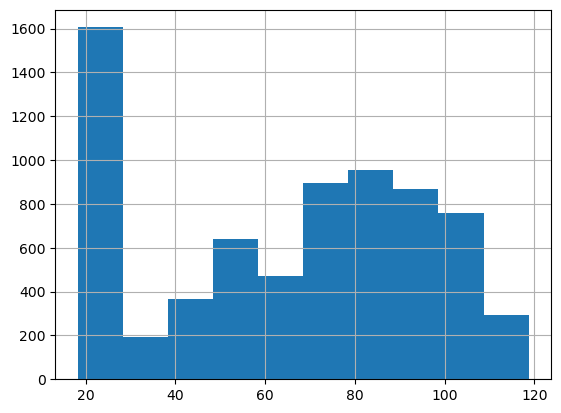

In [22]:
dfc.df['monthlycharges'].hist()

            monthlycharges monthlycharges_group
customerID                                     
7590-VHVEG           29.85                    1
5575-GNVDE           56.95                    2
3668-QPYBK           53.85                    2
7795-CFOCW           42.30                    1
9237-HQITU           70.70                    2
...                    ...                  ...
6840-RESVB           84.80                    2
2234-XADUH          103.20                    3
4801-JZAZL           29.60                    1
8361-LTMKD           74.40                    2
3186-AJIEK          105.65                    3

[7043 rows x 2 columns]


<AxesSubplot: >

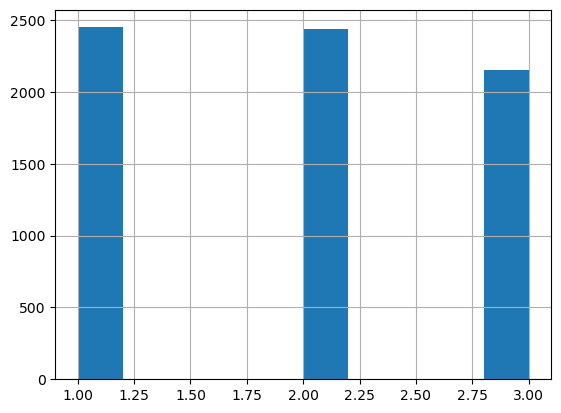

In [28]:
df = dfc.df
bins = pd.cut(df['monthlycharges'], bins=3, labels=[1, 2, 3])

# add new column with bins
df['monthlycharges_group'] = bins

# view dataframe
print(df[['monthlycharges','monthlycharges_group']])
df['monthlycharges_group'].hist()



## Features affecting the label

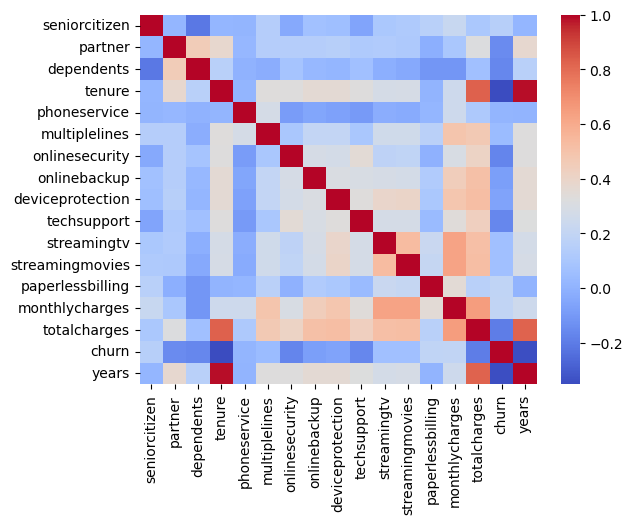

In [50]:
dfc.corr()

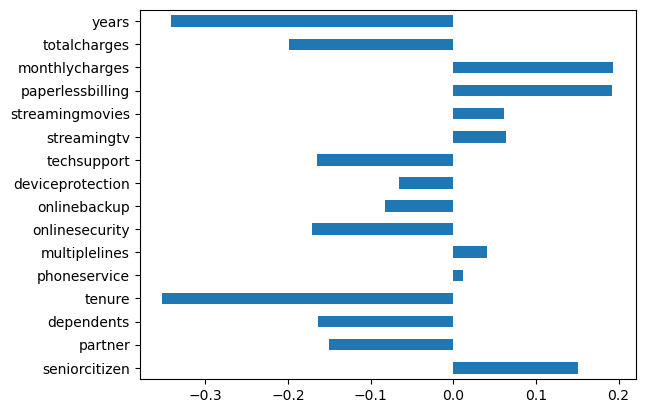

In [51]:
dfc.features_correlation_to_label()

# Check df before models

In [10]:
# Optional - insert nulls and you'll be asked to replace them with a value
# dfc.df.loc['7590-VHVEG','tenure']=np.nan
# dfc.df.loc['7590-VHVEG','years']=np.nan

dfc.check_before_model()

The data contains no nulls


In [11]:
accuracy_scores = []

for n in range(0,23):
    dfc = df_class(file)
    acc = dfc.remove_uncontributing_features(n)
    print(f'{n} features removed, {dfc.df_dummies.shape[1]} are left, accuracy: {acc}')
    accuracy_scores.append(acc)

    # Plot the results
plt.plot(range(0, 23), accuracy_scores)
plt.xlabel('n')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for remove_uncontributing_features(n)')
plt.show()

# Find the value of n with the highest accuracy score
best_n = accuracy_scores.index(max(accuracy_scores)) + 1
print(f"The value of n with the highest accuracy score is {best_n}")

AttributeError: 'df_class' object has no attribute 'df_dummies'

# Calculated features

## count paid services

In [209]:
list_of_columns_to_count = ['phoneservice', 'multiplelines', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies']
dfc.add_columns_counter(list_of_columns_to_count)
dfc.df = dfc.df.drop(columns=list_of_columns_to_count)


In [210]:
pd.set_option('display.max_rows', 5)
dfc.df


,gender,seniorcitizen,partner,dependents,tenure,internetservice,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,monthlycharges_group,years,columns_counter
customerID,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,1,0,1,DSL,Month-to-month,1,Electronic check,29.85,29.85,0,1,0,1
5575-GNVDE,Male,0,0,0,34,DSL,One year,0,Mailed check,56.95,1889.50,0,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8361-LTMKD,Male,1,1,0,4,Fiber optic,Month-to-month,1,Mailed check,74.40,306.60,1,5,0,2
3186-AJIEK,Male,0,0,0,66,Fiber optic,Two year,1,Bank transfer (automatic),105.65,6844.50,0,8,5,6


## Remove uncontributing features

In [41]:
dfc.random_forest()[1].sort_values('importance', ascending=False)

,feature,importance
15,years,0.184814
3,tenure,0.156695
18,internetservice_Fiber optic,0.122165
22,paymentmethod_Electronic check,0.120841
20,contract_Two year,0.088683
13,monthlycharges,0.084906
14,totalcharges,0.075102
12,paperlessbilling,0.039200
19,contract_One year,0.027830
6,onlinesecurity,0.025250


# ML models

## Decision tree

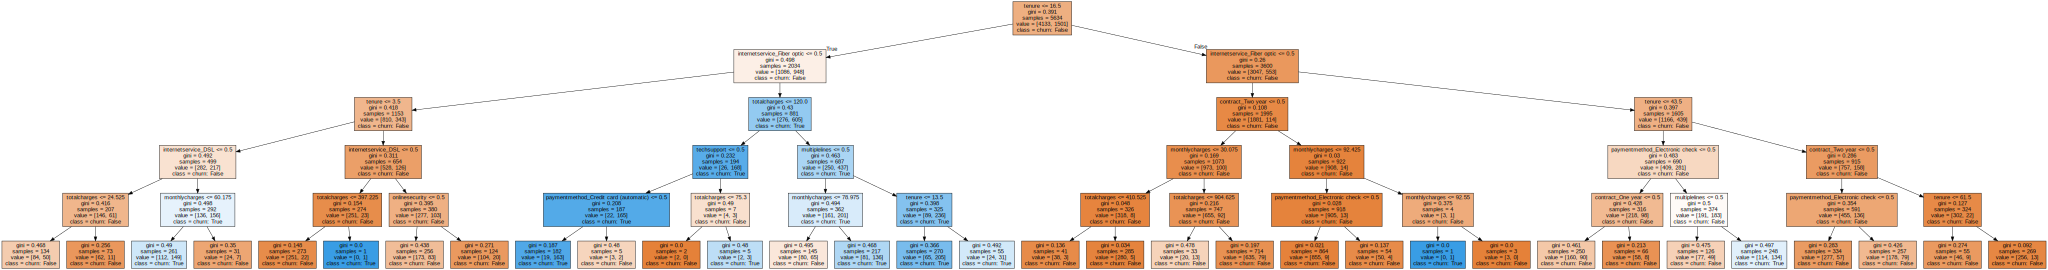

0.794889992902768

In [222]:
dfc.decision_tree(draw=True)

{'accuracy': 0.794889992902768, 'max_depth': 5}

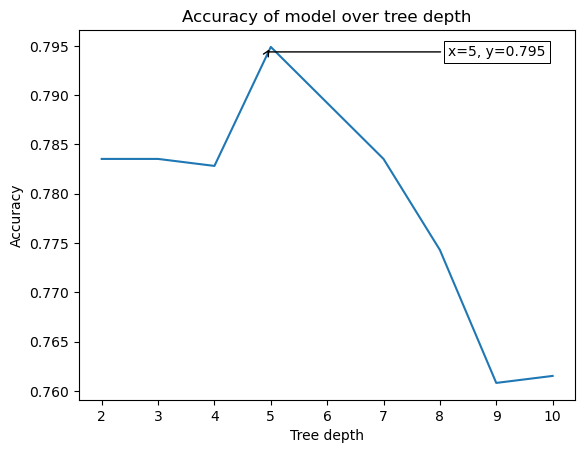

In [223]:
d = dfc.compare_decision_tree_depths(range(2,11), draw=True)
d

## Random forest

(0.7700496806245565,
                    feature  importance
 0            seniorcitizen    0.004766
 1                  partner    0.038557
 ..                     ...         ...
 31  monthlycharges_group_8    0.000000
 32  monthlycharges_group_9    0.000000
 
 [33 rows x 2 columns])

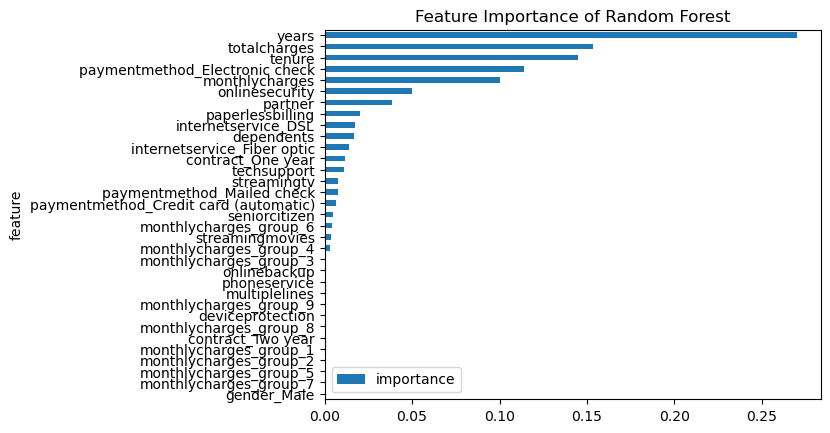

In [217]:
d=dfc.random_forest(n_estimators=10, draw=True)
d

{'accuracy': 0.7955997161107168, 'n_estimators': 200, 'max_depth': 10}

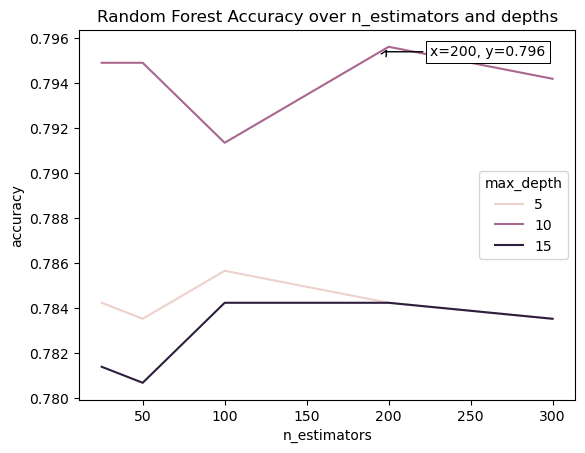

In [219]:
d = dfc.compare_random_forest([25, 50, 100, 200, 300 ], [5, 10, 15], draw=True)
d

## KNN

In [213]:
dfc.knn()

0.7828246983676366

{'accuracy': 0.7934705464868701, 'neighbours': 37}

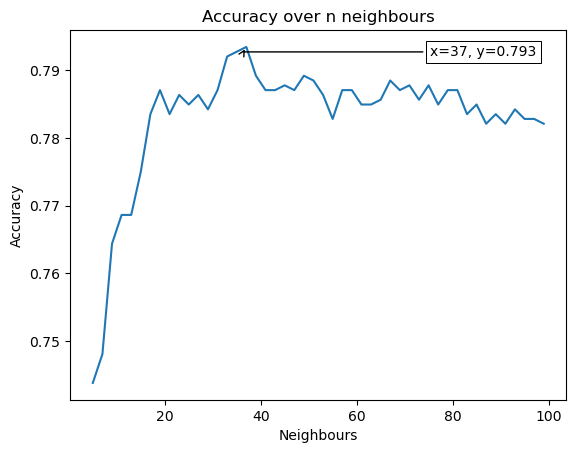

In [216]:
d = dfc.compare_knn(range(5,100,2), draw=True)
d

# Compare methods

In [145]:
# get start time
start_time = time.time()
print('Start time: {}'.format(time.ctime(start_time)))

# your code here
accs = dfc.compare_methods()

# get end time
end_time = time.time()

# calculate total runtime
total_time = end_time - start_time

# print start time and total runtime
print('Total runtime: {:.2f} seconds'.format(total_time))


{'Decision tree (max_depth=5)': 0.794889992902768,
 'Random forest (n_estimators=39, max_depth=10': 0.7984386089425124,
 'KNN (neighbours=18': 0.7906316536550745,
 'Benchmark': 0.7388218594748048}

# Customers on focus

In [227]:
from sklearn.ensemble import RandomForestClassifier

# Filter the DataFrame to keep only the customers who haven't churned
df = dfc.df
X = df.drop('churn', axis=1)
y = df['churn']
rf = RandomForestClassifier()
rf.fit(X, y)

# Filter the DataFrame to keep only the customers who haven't churned
df_not_churned = df[df['churn'] == 0].copy()

# Remove the 'churn' column from the filtered DataFrame
X_not_churned = df_not_churned.drop('churn', axis=1)

# Use the trained random forest model to predict the probability of churn for each customer who hasn't churned
proba_not_churned = rf.predict_proba(X_not_churned)

# Add a new column to the filtered DataFrame with the predicted probability of churn for each customer who hasn't churned
df_not_churned['churn_proba'] = proba_not_churned[:, 1]

# Print the resulting DataFrame
print(df_not_churned)

ValueError: could not convert string to float: 'Female'

In [50]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

df = pd.get_dummies(dfc.df)

# create X matrix and y vector
X = df.drop('churn', axis=1)
y = df['churn']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create SelectKBest object and fit it to training data
selector = SelectKBest(f_classif, k=5)
selector.fit(X_train, y_train)

# transform the training and testing data to select the top k features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# create a random forest classifier and fit it to the selected features
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_selected, y_train)

# evaluate the model on the testing data
y_pred = rfc.predict(X_test_selected)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1036
           1       0.69      0.44      0.54       373

    accuracy                           0.80      1409
   macro avg       0.75      0.68      0.70      1409
weighted avg       0.79      0.80      0.78      1409



In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

df = pd.get_dummies(dfc.df)

# define the pipeline with SelectKBest and RandomForestClassifier
pipeline = Pipeline([
    ('feature_selection', SelectKBest()),
    ('classification', RandomForestClassifier())
])

# define the parameters for grid search
parameters = {
    'feature_selection__k': range(1, 25),
    'classification__n_estimators': [10, 50, 100, 200]
}

# perform grid search
grid_search = GridSearchCV(pipeline, parameters, cv=5)
grid_search.fit(X_train, y_train)

# print the best parameters and performance
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)


Best parameters: {'classification__n_estimators': 200, 'feature_selection__k': 20}
Best score: 0.7921514702104487
